#Experiment [1] Custom PyTorch Implementation

Loading data...

Training Model 1 (Fire Dataset)
Early stopping at epoch 16

Training Model 2 (Diabetes Dataset)
Early stopping at epoch 7

==================== Evaluation for Fire Dataset ====================

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       453
           1       0.67      0.69      0.68       279

    accuracy                           0.75       732
   macro avg       0.74      0.74      0.74       732
weighted avg       0.75      0.75      0.75       732


--- Confusion Matrix ---


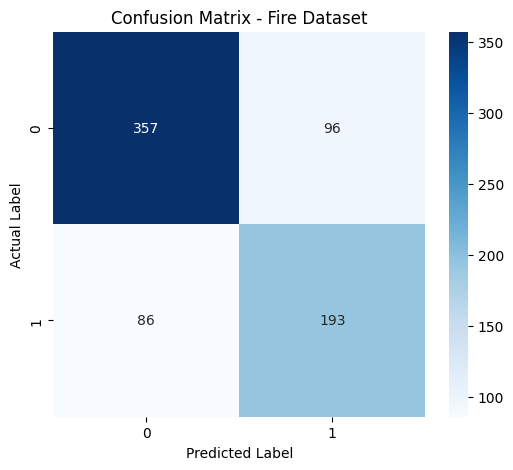


--- ROC Curve ---


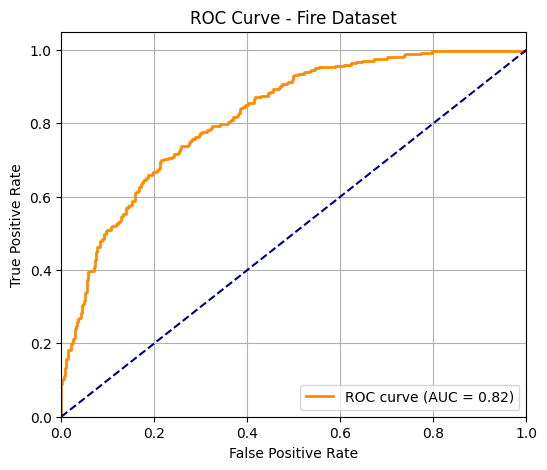


==================== Evaluation for Diabetes Dataset ====================

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       476
           1       0.75      0.74      0.74       524

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000


--- Confusion Matrix ---


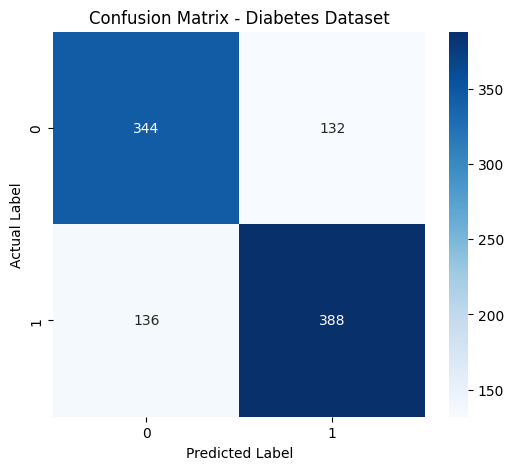


--- ROC Curve ---


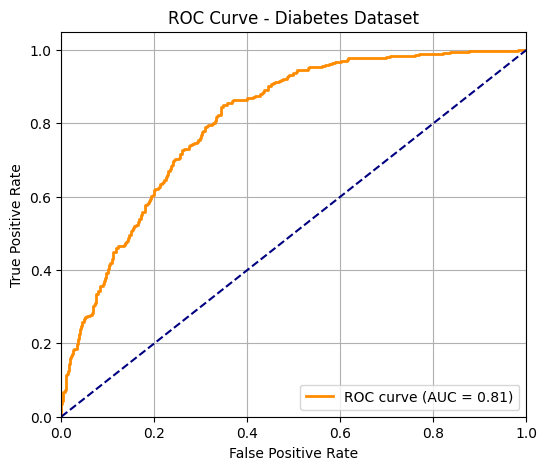

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Model Definition ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.BatchNorm1d(hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, output_size)
        )

    def forward(self, x):
        return self.network(x)

# --- 2. Utility Classes & Functions ---

class Datasett(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def transform_to_tensors(X_train, X_test, y_train, y_test):
    return (
        torch.tensor(np.array(X_train), dtype=torch.float32),
        torch.tensor(np.array(X_test), dtype=torch.float32),
        torch.tensor(np.array(y_train), dtype=torch.long),
        torch.tensor(np.array(y_test), dtype=torch.long)
    )

def train(X_train_full, y_train_full, input_size, epochs, h1, h2, h3, lr, threshold, output_size, patience, delta):
    # Ensure inputs are tensors
    if not isinstance(X_train_full, torch.Tensor):
         X_train_full = torch.tensor(X_train_full.values, dtype=torch.float32)
    if not isinstance(y_train_full, torch.Tensor):
         y_train_full = torch.tensor(y_train_full.values, dtype=torch.long)

    # Internal split for validation during training
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    model = MLP(input_size, h1, h2, h3, output_size)
    early_stopping = EarlyStopping(patience, delta)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = Datasett(X_train, y_train)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y.float())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs.squeeze(), y_val.float())
            early_stopping(val_loss.item())
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch}")
                break

    return model

def plot_roc_curve(y_true, y_probs, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_preds, dataset_name):
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- 3. Pipeline Class ---

class Pipeline:
    def __init__(self, epochs=50, h1=64, h2=32, h3=16, lr=0.001, threshold=0.5, output_size=1, patience=5, delta=0.001):
        self.epochs = epochs
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.lr = lr
        self.threshold = threshold
        self.output_size = output_size
        self.patience = patience
        self.delta = delta

    def load_and_preprocess_data(self):
        # --- Load Dataset 1: Fire ---
        # Target identified as 'FIRE_START_DAY'
        df1 = pd.read_csv('Processed_Fire_Dataset.csv')
        X1 = df1.drop('FIRE_START_DAY', axis=1)
        y1 = df1['FIRE_START_DAY']

        # --- Load Dataset 2: Diabetes ---
        # Target identified as 'Diabetes_binary'
        df2 = pd.read_csv('Processed_Diabetes_dataset.csv')
        X2 = df2.drop('Diabetes_binary', axis=1)
        y2 = df2['Diabetes_binary']

        return X1, y1, X2, y2

    def run(self):
        # 1. Load Data
        print("Loading data...")
        X1, y1, X2, y2 = self.load_and_preprocess_data()

        # 2. Split Data
        X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

        # 3. Scaling (StandardScaler)
        scaler1 = StandardScaler()
        X1_train_scaled = scaler1.fit_transform(X1_train)
        X1_test_scaled = scaler1.transform(X1_test)

        scaler2 = StandardScaler()
        X2_train_scaled = scaler2.fit_transform(X2_train)
        X2_test_scaled = scaler2.transform(X2_test)

        # 4. Transform to Tensors
        self.X1_train, self.X1_test, self.y1_train, self.y1_test = transform_to_tensors(
            X1_train_scaled, X1_test_scaled, y1_train, y1_test
        )
        self.X2_train, self.X2_test, self.y2_train, self.y2_test = transform_to_tensors(
            X2_train_scaled, X2_test_scaled, y2_train, y2_test
        )

        # 5. Training
        print("\n" + "="*40)
        print("Training Model 1 (Fire Dataset)")
        print("="*40)
        input_size1 = self.X1_train.shape[1]
        self.model1 = train(self.X1_train, self.y1_train, input_size1, self.epochs, self.h1, self.h2, self.h3, self.lr, self.threshold, self.output_size, self.patience, self.delta)

        print("\n" + "="*40)
        print("Training Model 2 (Diabetes Dataset)")
        print("="*40)
        input_size2 = self.X2_train.shape[1]
        self.model2 = train(self.X2_train, self.y2_train, input_size2, self.epochs, self.h1, self.h2, self.h3, self.lr, self.threshold, self.output_size, self.patience, self.delta)

        # 6. Evaluation
        self.evaluate(self.model1, self.X1_test, self.y1_test, "Fire Dataset")
        self.evaluate(self.model2, self.X2_test, self.y2_test, "Diabetes Dataset")

    def evaluate(self, model, X_test, y_test, dataset_name):
        model.eval()
        with torch.no_grad():
            logits = model(X_test)
            probs = torch.sigmoid(logits.squeeze())
            preds = (probs > self.threshold).long()

        print(f"\n{'='*20} Evaluation for {dataset_name} {'='*20}")

        # 1. Classification Report
        print("\n--- Classification Report ---")
        print(classification_report(y_test, preds))

        # 2. Confusion Matrix
        print("\n--- Confusion Matrix ---")
        plot_confusion_matrix(y_test, preds, dataset_name)

        # 3. ROC Curve
        print("\n--- ROC Curve ---")
        plot_roc_curve(y_test, probs, dataset_name)

# --- Execute ---
if __name__ == "__main__":
    pipeline = Pipeline(epochs=50, lr=0.001, patience=5)
    pipeline.run()

#Experiment 2: Tanh Activation and Hyperparameter Robustness 7-Fold Cross-Validation


############################################################
RUNNING EXPERIMENT: BASIC_MODEL
############################################################

LOADING DATA FOR: BASIC_MODEL...

[BASIC_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4674

[BASIC_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.5041

>>> Evaluation for BASIC_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       453
           1       0.69      0.66      0.68       279

    accuracy                           0.76       732
   macro avg       0.74      0.74      0.74       732
weighted avg       0.76      0.76      0.76       732



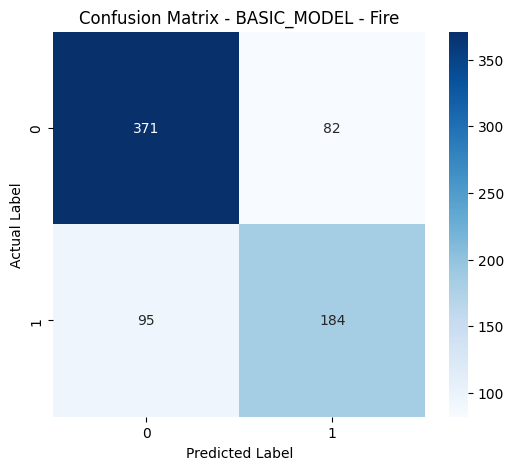

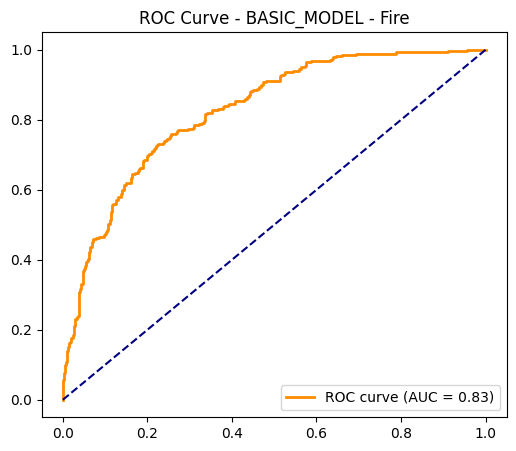


>>> Evaluation for BASIC_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       476
           1       0.76      0.73      0.74       524

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



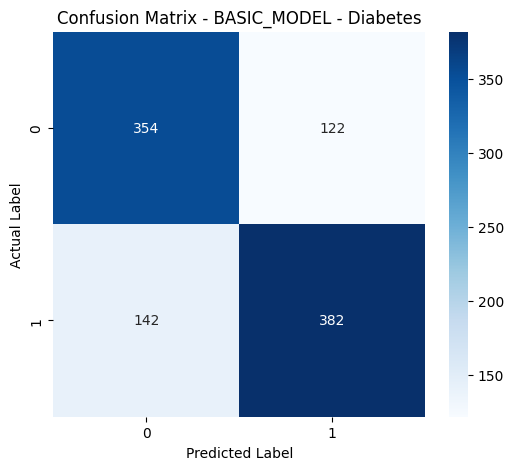

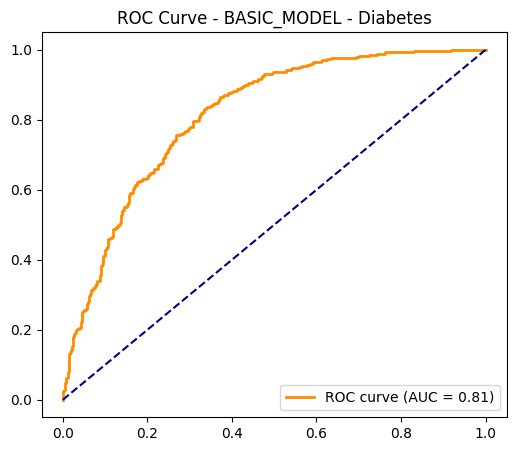


############################################################
RUNNING EXPERIMENT: MODERATE_MODEL
############################################################

LOADING DATA FOR: MODERATE_MODEL...

[MODERATE_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4634

[MODERATE_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4959

>>> Evaluation for MODERATE_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       453
           1       0.68      0.69      0.68       279

    accuracy                           0.76       732
   macro avg       0.74      0.74      0.74       732
weighted avg       0.76      0.76      0.76       732



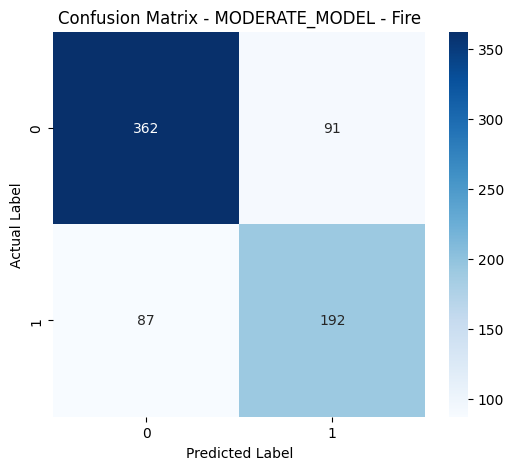

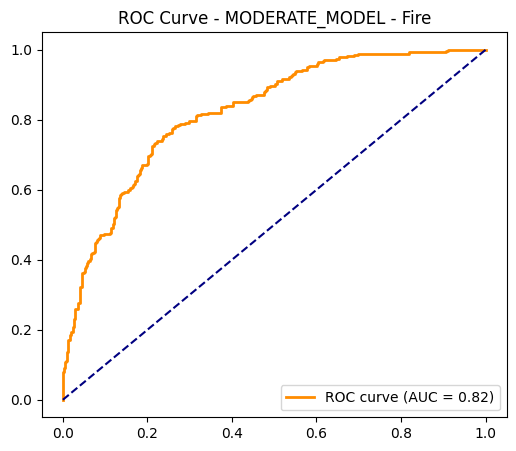


>>> Evaluation for MODERATE_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       476
           1       0.74      0.75      0.75       524

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



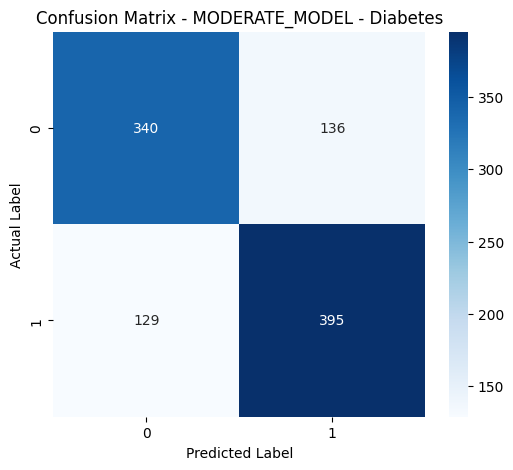

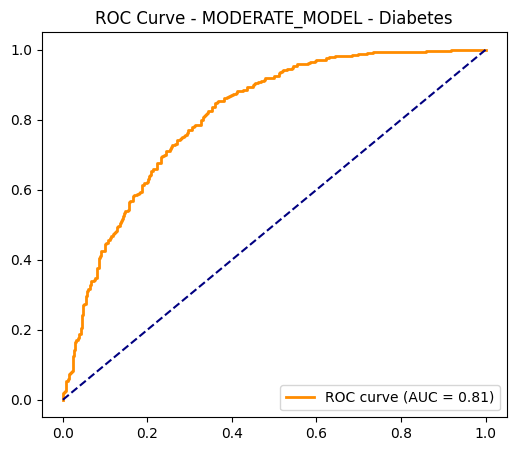


############################################################
RUNNING EXPERIMENT: AGGRESSIVE_MODEL
############################################################

LOADING DATA FOR: AGGRESSIVE_MODEL...

[AGGRESSIVE_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4805

[AGGRESSIVE_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4979

>>> Evaluation for AGGRESSIVE_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       453
           1       0.69      0.66      0.68       279

    accuracy                           0.76       732
   macro avg       0.75      0.74      0.74       732
weighted avg       0.76      0.76      0.76       732



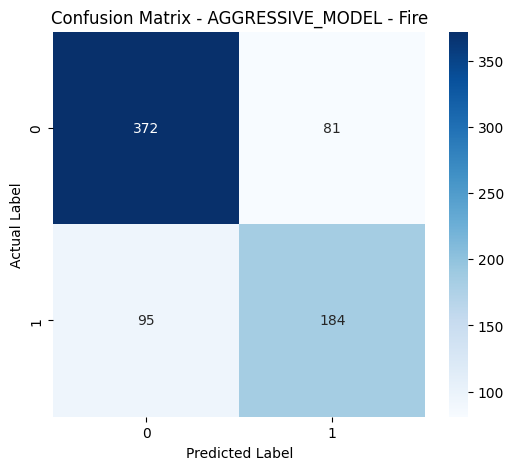

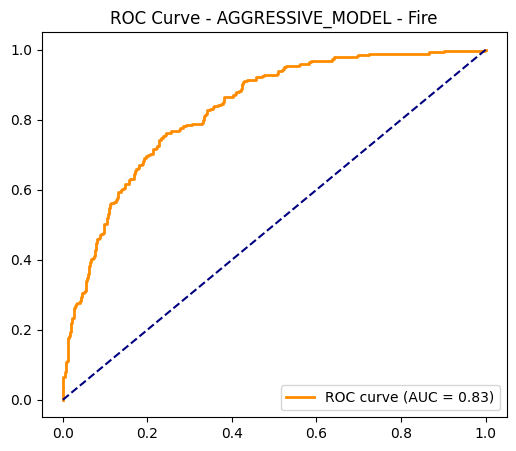


>>> Evaluation for AGGRESSIVE_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       476
           1       0.75      0.76      0.75       524

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000



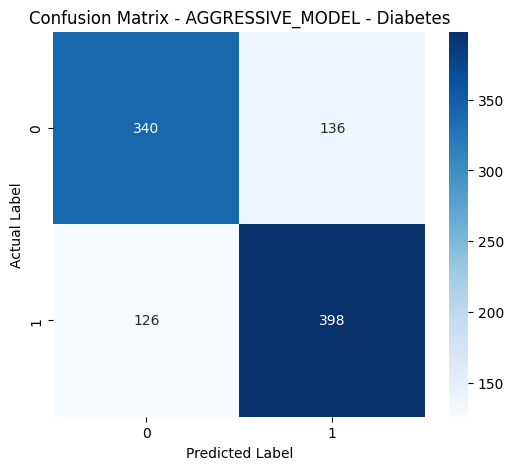

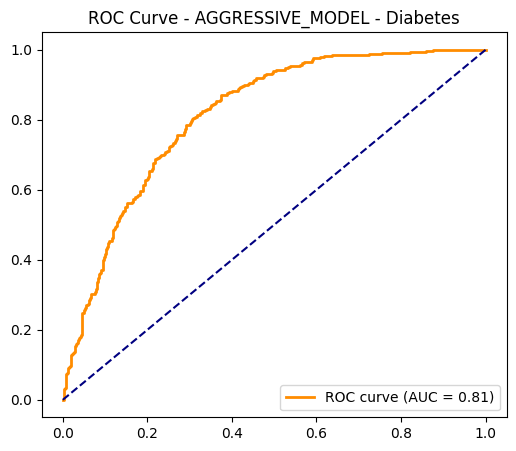

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Model Definition ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.Tanh(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.Tanh(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.BatchNorm1d(hidden_size3),
            nn.Tanh(),
            nn.Linear(hidden_size3, output_size)
        )

    def forward(self, x):
        return self.network(x)

# --- 2. Utility Classes & Functions ---

class Datasett(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def transform_to_tensors(X_train, X_test, y_train, y_test):
    return (
        torch.tensor(np.array(X_train), dtype=torch.float32),
        torch.tensor(np.array(X_test), dtype=torch.float32),
        torch.tensor(np.array(y_train), dtype=torch.long),
        torch.tensor(np.array(y_test), dtype=torch.long)
    )

# CORRECTED TRAIN FUNCTION
def train(X_train_full, y_train_full, input_size, epochs, h1, h2, h3, lr, threshold, output_size, patience, delta, weight_decay, batch_size):
    # Ensure inputs are tensors
    if not isinstance(X_train_full, torch.Tensor):
         X_train_full = torch.tensor(X_train_full.values, dtype=torch.float32)
    if not isinstance(y_train_full, torch.Tensor):
         y_train_full = torch.tensor(y_train_full.values, dtype=torch.long)

    # --- CV CONFIGURATION ---
    k_folds = 7
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    best_overall_model = None
    best_overall_loss = float('inf')

    print(f"Starting {k_folds}-Fold Cross-Validation...")

    # --- CROSS-VALIDATION LOOP ---
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_full)):
        # Split data for this specific fold
        X_train_fold = X_train_full[train_idx]
        y_train_fold = y_train_full[train_idx]
        X_val_fold = X_train_full[val_idx]
        y_val_fold = y_train_full[val_idx]

        # Re-initialize a FRESH model for every fold
        model = MLP(input_size, h1, h2, h3, output_size)
        criterion = nn.BCEWithLogitsLoss()

        # Optimizer with Weight Decay (Regularization)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

        early_stopping = EarlyStopping(patience, delta)

        dataset = Datasett(X_train_fold, y_train_fold)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Training Loop for this fold
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y.float())
                loss.backward()
                optimizer.step()

            # Validation step
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_fold)
                val_loss = criterion(val_outputs.squeeze(), y_val_fold.float())

                # Update scheduler
                scheduler.step(val_loss)

                # Check early stopping
                early_stopping(val_loss.item())
                if early_stopping.early_stop:
                    break

        # Get the best loss achieved by THIS fold
        fold_best_loss = early_stopping.best_loss

        if fold_best_loss < best_overall_loss:
            best_overall_loss = fold_best_loss
            best_overall_model = model

    print(f"   -> Best CV Loss: {best_overall_loss:.4f}")
    return best_overall_model

def plot_roc_curve(y_true, y_probs, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_preds, dataset_name):
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- 3. Pipeline Class ---

class Pipeline:
    def __init__(self, epochs=50, h1=128, h2=64, h3=32, lr=0.001,
                 threshold=0.5, output_size=1, patience=5, delta=0.001,
                 weight_decay=0.0001, batch_size=64):

        self.epochs = epochs
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.lr = lr
        self.threshold = threshold
        self.output_size = output_size
        self.patience = patience
        self.delta = delta
        self.weight_decay = weight_decay
        self.batch_size = batch_size

    def load_and_preprocess_data(self):
        df1 = pd.read_csv('Processed_Fire_Dataset.csv')
        X1 = df1.drop('FIRE_START_DAY', axis=1)
        y1 = df1['FIRE_START_DAY']

        df2 = pd.read_csv('Processed_Diabetes_dataset.csv')
        X2 = df2.drop('Diabetes_binary', axis=1)
        y2 = df2['Diabetes_binary']
        return X1, y1, X2, y2

    def run(self, config_name):
        print(f"\nLOADING DATA FOR: {config_name}...")
        X1, y1, X2, y2 = self.load_and_preprocess_data()

        X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

        scaler1 = StandardScaler()
        X1_train_scaled = scaler1.fit_transform(X1_train)
        X1_test_scaled = scaler1.transform(X1_test)

        scaler2 = StandardScaler()
        X2_train_scaled = scaler2.fit_transform(X2_train)
        X2_test_scaled = scaler2.transform(X2_test)

        self.X1_train, self.X1_test, self.y1_train, self.y1_test = transform_to_tensors(
            X1_train_scaled, X1_test_scaled, y1_train, y1_test
        )
        self.X2_train, self.X2_test, self.y2_train, self.y2_test = transform_to_tensors(
            X2_train_scaled, X2_test_scaled, y2_train, y2_test
        )

        print(f"\n[{config_name}] Training Model 1 (Fire Dataset)")
        input_size1 = self.X1_train.shape[1]
        self.model1 = train(self.X1_train, self.y1_train, input_size1, self.epochs,
                            self.h1, self.h2, self.h3, self.lr, self.threshold,
                            self.output_size, self.patience, self.delta,
                            self.weight_decay, self.batch_size)

        print(f"\n[{config_name}] Training Model 2 (Diabetes Dataset)")
        input_size2 = self.X2_train.shape[1]
        self.model2 = train(self.X2_train, self.y2_train, input_size2, self.epochs,
                            self.h1, self.h2, self.h3, self.lr, self.threshold,
                            self.output_size, self.patience, self.delta,
                            self.weight_decay, self.batch_size)

        self.evaluate(self.model1, self.X1_test, self.y1_test, f"{config_name} - Fire")
        self.evaluate(self.model2, self.X2_test, self.y2_test, f"{config_name} - Diabetes")

    def evaluate(self, model, X_test, y_test, dataset_name):
        model.eval()
        with torch.no_grad():
            logits = model(X_test)
            probs = torch.sigmoid(logits.squeeze())
            preds = (probs > self.threshold).long()

        print(f"\n>>> Evaluation for {dataset_name} <<<")
        print(classification_report(y_test, preds))
        plot_confusion_matrix(y_test, preds, dataset_name)
        plot_roc_curve(y_test, probs, dataset_name)


# --- 4. EXECUTION BLOCK ---
if __name__ == "__main__":

    # Define the 3 Configurations
    experiments = [
        {
            "name": "BASIC_MODEL",
            "h1": 64, "h2": 32, "h3": 16,
            "lr": 0.001,
            "weight_decay": 0.0,    # No regularization
            "patience": 5,
            "batch_size": 32,
            "epochs": 50
        },
        {
            "name": "MODERATE_MODEL",
            "h1": 128, "h2": 64, "h3": 32,
            "lr": 0.001,
            "weight_decay": 0.0001, # Standard regularization
            "patience": 8,
            "batch_size": 64,
            "epochs": 75
        },
        {
            "name": "AGGRESSIVE_MODEL",
            "h1": 256, "h2": 128, "h3": 64,
            "lr": 0.01,             # High learning rate
            "weight_decay": 0.001,  # High regularization to combat overfitting
            "patience": 15,         # Wait longer for convergence
            "batch_size": 128,
            "epochs": 150
        }
    ]

    # Loop through experiments
    for exp in experiments:
        print(f"\n{'#'*60}")
        print(f"RUNNING EXPERIMENT: {exp['name']}")
        print(f"{'#'*60}")

        pipeline = Pipeline(
            epochs=exp['epochs'],
            h1=exp['h1'], h2=exp['h2'], h3=exp['h3'],
            lr=exp['lr'],
            weight_decay=exp['weight_decay'],
            patience=exp['patience'],
            batch_size=exp['batch_size']
        )

        pipeline.run(exp['name'])

#Experiment 3: SiLU (Swish) Activation with Cross-Validation


############################################################
RUNNING EXPERIMENT: BASIC_MODEL
############################################################

LOADING DATA FOR: BASIC_MODEL...

[BASIC_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4569

[BASIC_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4952

>>> Evaluation for BASIC_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       453
           1       0.70      0.65      0.67       279

    accuracy                           0.76       732
   macro avg       0.75      0.74      0.74       732
weighted avg       0.76      0.76      0.76       732



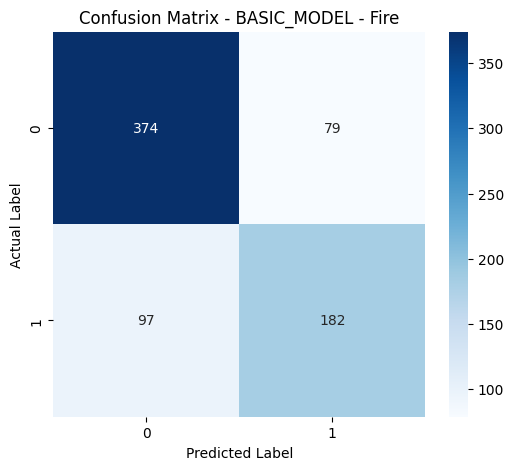

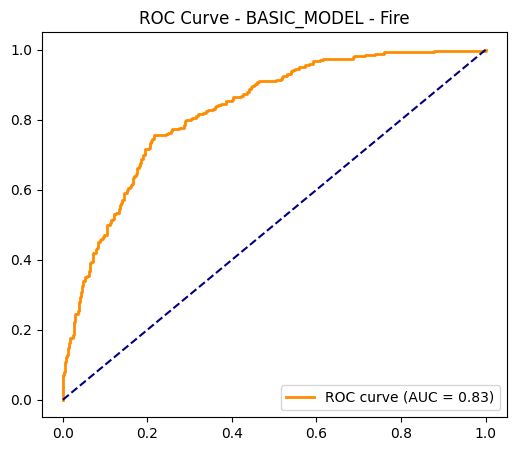


>>> Evaluation for BASIC_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       476
           1       0.76      0.70      0.73       524

    accuracy                           0.72      1000
   macro avg       0.73      0.73      0.72      1000
weighted avg       0.73      0.72      0.73      1000



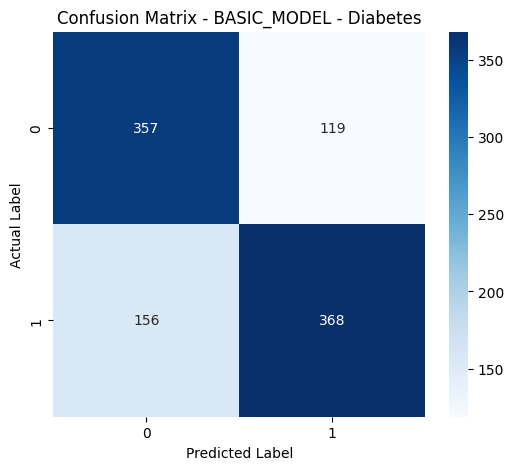

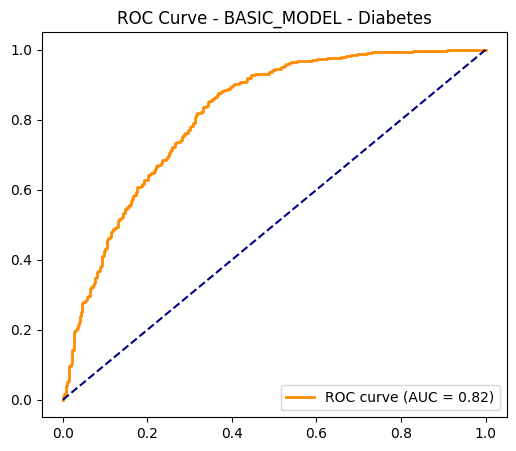


############################################################
RUNNING EXPERIMENT: MODERATE_MODEL
############################################################

LOADING DATA FOR: MODERATE_MODEL...

[MODERATE_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4603

[MODERATE_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4972

>>> Evaluation for MODERATE_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       453
           1       0.69      0.66      0.67       279

    accuracy                           0.76       732
   macro avg       0.74      0.74      0.74       732
weighted avg       0.75      0.76      0.75       732



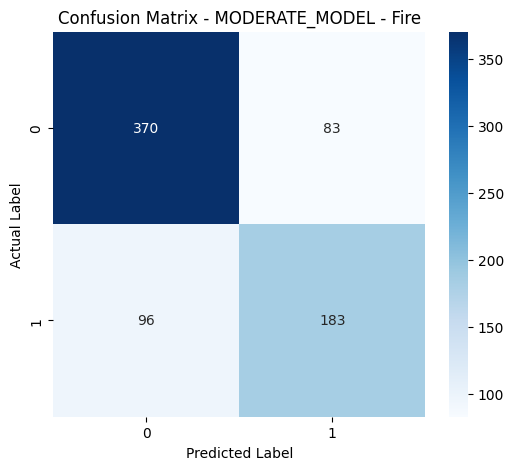

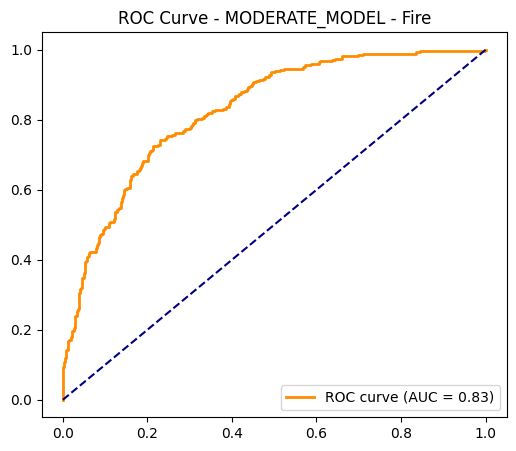


>>> Evaluation for MODERATE_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       476
           1       0.74      0.74      0.74       524

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



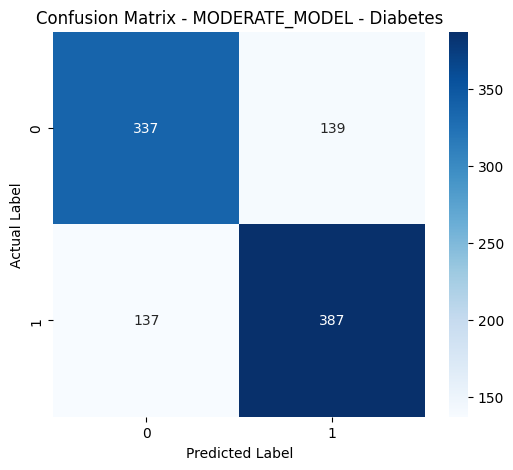

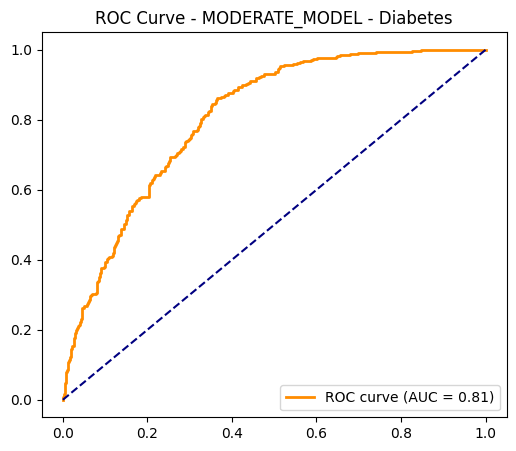


############################################################
RUNNING EXPERIMENT: AGGRESSIVE_MODEL
############################################################

LOADING DATA FOR: AGGRESSIVE_MODEL...

[AGGRESSIVE_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4669

[AGGRESSIVE_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4914

>>> Evaluation for AGGRESSIVE_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       453
           1       0.71      0.66      0.68       279

    accuracy                           0.77       732
   macro avg       0.75      0.75      0.75       732
weighted avg       0.77      0.77      0.77       732



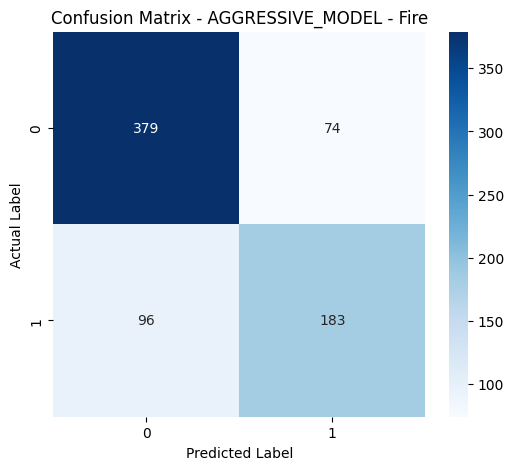

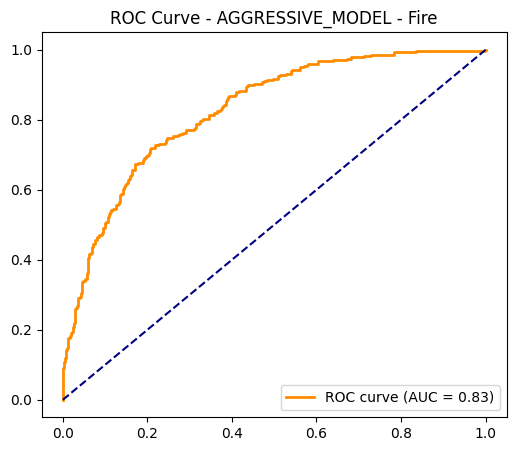


>>> Evaluation for AGGRESSIVE_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       476
           1       0.74      0.79      0.76       524

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



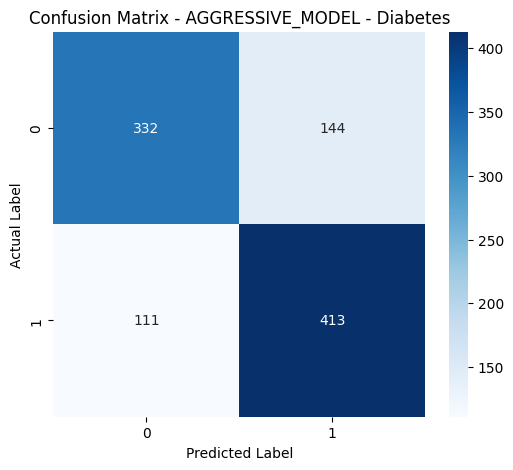

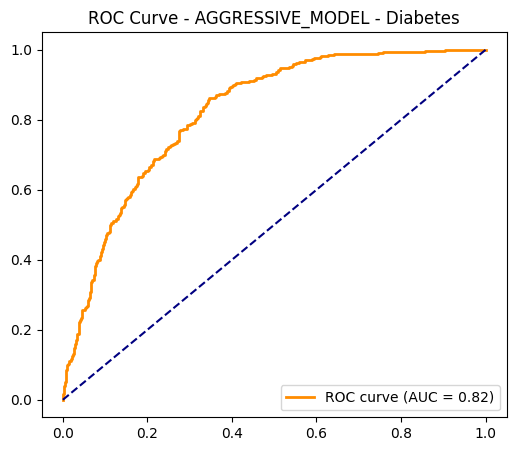

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Model Definition ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.SiLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.SiLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.BatchNorm1d(hidden_size3),
            nn.SiLU(),
            nn.Linear(hidden_size3, output_size)
        )

    def forward(self, x):
        return self.network(x)

# --- 2. Utility Classes & Functions ---

class Datasett(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def transform_to_tensors(X_train, X_test, y_train, y_test):
    return (
        torch.tensor(np.array(X_train), dtype=torch.float32),
        torch.tensor(np.array(X_test), dtype=torch.float32),
        torch.tensor(np.array(y_train), dtype=torch.long),
        torch.tensor(np.array(y_test), dtype=torch.long)
    )

#  TRAIN FUNCTION
def train(X_train_full, y_train_full, input_size, epochs, h1, h2, h3, lr, threshold, output_size, patience, delta, weight_decay, batch_size):
    # Ensure inputs are tensors
    if not isinstance(X_train_full, torch.Tensor):
         X_train_full = torch.tensor(X_train_full.values, dtype=torch.float32)
    if not isinstance(y_train_full, torch.Tensor):
         y_train_full = torch.tensor(y_train_full.values, dtype=torch.long)

    # --- CV CONFIGURATION ---
    k_folds = 7
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    best_overall_model = None
    best_overall_loss = float('inf')

    print(f"Starting {k_folds}-Fold Cross-Validation...")

    # --- CROSS-VALIDATION LOOP ---
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_full)):
        # Split data for this specific fold
        X_train_fold = X_train_full[train_idx]
        y_train_fold = y_train_full[train_idx]
        X_val_fold = X_train_full[val_idx]
        y_val_fold = y_train_full[val_idx]

        # Re-initialize a FRESH model for every fold
        model = MLP(input_size, h1, h2, h3, output_size)
        criterion = nn.BCEWithLogitsLoss()

        # Optimizer with Weight Decay (Regularization)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

        early_stopping = EarlyStopping(patience, delta)

        dataset = Datasett(X_train_fold, y_train_fold)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Training Loop for this fold
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y.float())
                loss.backward()
                optimizer.step()

            # Validation step
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_fold)
                val_loss = criterion(val_outputs.squeeze(), y_val_fold.float())

                # Update scheduler
                scheduler.step(val_loss)

                # Check early stopping
                early_stopping(val_loss.item())
                if early_stopping.early_stop:
                    break

        # Get the best loss achieved by THIS fold
        fold_best_loss = early_stopping.best_loss

        # save the best model
        if fold_best_loss < best_overall_loss:
            best_overall_loss = fold_best_loss
            best_overall_model = model

    print(f"   -> Best CV Loss: {best_overall_loss:.4f}")
    return best_overall_model

def plot_roc_curve(y_true, y_probs, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_preds, dataset_name):
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- 3. Pipeline Class ---

class Pipeline:
    def __init__(self, epochs=50, h1=128, h2=64, h3=32, lr=0.001,
                 threshold=0.5, output_size=1, patience=5, delta=0.001,
                 weight_decay=0.0001, batch_size=64):

        self.epochs = epochs
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.lr = lr
        self.threshold = threshold
        self.output_size = output_size
        self.patience = patience
        self.delta = delta
        self.weight_decay = weight_decay
        self.batch_size = batch_size

    def load_and_preprocess_data(self):
        df1 = pd.read_csv('Processed_Fire_Dataset.csv')
        X1 = df1.drop('FIRE_START_DAY', axis=1)
        y1 = df1['FIRE_START_DAY']

        df2 = pd.read_csv('Processed_Diabetes_dataset.csv')
        X2 = df2.drop('Diabetes_binary', axis=1)
        y2 = df2['Diabetes_binary']
        return X1, y1, X2, y2

    def run(self, config_name):
        print(f"\nLOADING DATA FOR: {config_name}...")
        X1, y1, X2, y2 = self.load_and_preprocess_data()

        X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

        scaler1 = StandardScaler()
        X1_train_scaled = scaler1.fit_transform(X1_train)
        X1_test_scaled = scaler1.transform(X1_test)

        scaler2 = StandardScaler()
        X2_train_scaled = scaler2.fit_transform(X2_train)
        X2_test_scaled = scaler2.transform(X2_test)

        self.X1_train, self.X1_test, self.y1_train, self.y1_test = transform_to_tensors(
            X1_train_scaled, X1_test_scaled, y1_train, y1_test
        )
        self.X2_train, self.X2_test, self.y2_train, self.y2_test = transform_to_tensors(
            X2_train_scaled, X2_test_scaled, y2_train, y2_test
        )

        print(f"\n[{config_name}] Training Model 1 (Fire Dataset)")
        input_size1 = self.X1_train.shape[1]
        self.model1 = train(self.X1_train, self.y1_train, input_size1, self.epochs,
                            self.h1, self.h2, self.h3, self.lr, self.threshold,
                            self.output_size, self.patience, self.delta,
                            self.weight_decay, self.batch_size)

        print(f"\n[{config_name}] Training Model 2 (Diabetes Dataset)")
        input_size2 = self.X2_train.shape[1]
        self.model2 = train(self.X2_train, self.y2_train, input_size2, self.epochs,
                            self.h1, self.h2, self.h3, self.lr, self.threshold,
                            self.output_size, self.patience, self.delta,
                            self.weight_decay, self.batch_size)

        self.evaluate(self.model1, self.X1_test, self.y1_test, f"{config_name} - Fire")
        self.evaluate(self.model2, self.X2_test, self.y2_test, f"{config_name} - Diabetes")

    def evaluate(self, model, X_test, y_test, dataset_name):
        model.eval()
        with torch.no_grad():
            logits = model(X_test)
            probs = torch.sigmoid(logits.squeeze())
            preds = (probs > self.threshold).long()

        print(f"\n>>> Evaluation for {dataset_name} <<<")
        print(classification_report(y_test, preds))
        plot_confusion_matrix(y_test, preds, dataset_name)
        plot_roc_curve(y_test, probs, dataset_name)


# --- 4. EXECUTION BLOCK ---
if __name__ == "__main__":

    # Define the 3 Configurations
    experiments = [
        {
            "name": "BASIC_MODEL",
            "h1": 64, "h2": 32, "h3": 16,
            "lr": 0.001,
            "weight_decay": 0.0,    # No regularization
            "patience": 5,
            "batch_size": 32,
            "epochs": 50
        },
        {
            "name": "MODERATE_MODEL",
            "h1": 128, "h2": 64, "h3": 32,
            "lr": 0.001,
            "weight_decay": 0.0001, # Standard regularization
            "patience": 8,
            "batch_size": 64,
            "epochs": 75
        },
        {
            "name": "AGGRESSIVE_MODEL",
            "h1": 256, "h2": 128, "h3": 64,
            "lr": 0.01,             # High learning rate
            "weight_decay": 0.001,  # High regularization to combat overfitting
            "patience": 15,         # Wait longer for convergence
            "batch_size": 128,
            "epochs": 150
        }
    ]

    # Loop through experiments
    for exp in experiments:
        print(f"\n{'#'*60}")
        print(f"RUNNING EXPERIMENT: {exp['name']}")
        print(f"{'#'*60}")

        pipeline = Pipeline(
            epochs=exp['epochs'],
            h1=exp['h1'], h2=exp['h2'], h3=exp['h3'],
            lr=exp['lr'],
            weight_decay=exp['weight_decay'],
            patience=exp['patience'],
            batch_size=exp['batch_size']
        )

        pipeline.run(exp['name'])

# Experiment 4: GELU


############################################################
RUNNING EXPERIMENT: BASIC_MODEL
############################################################

LOADING DATA FOR: BASIC_MODEL...

[BASIC_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4572

[BASIC_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.5038

>>> Evaluation for BASIC_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       453
           1       0.66      0.71      0.68       279

    accuracy                           0.75       732
   macro avg       0.74      0.74      0.74       732
weighted avg       0.76      0.75      0.75       732



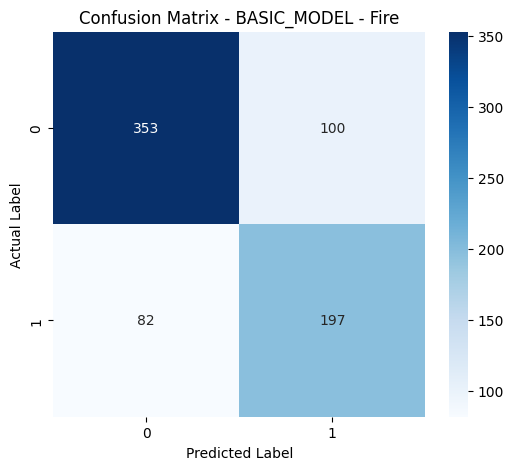

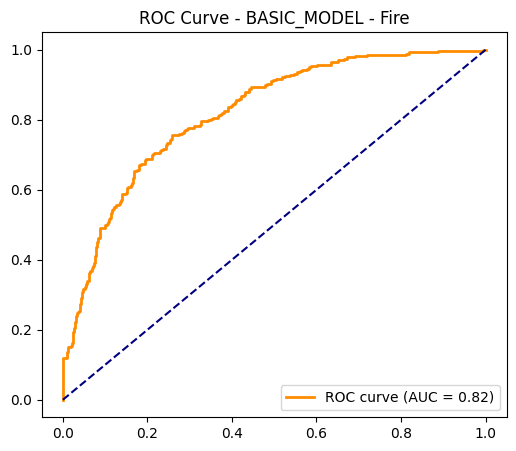


>>> Evaluation for BASIC_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       476
           1       0.73      0.81      0.77       524

    accuracy                           0.75      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.75      0.74      1000



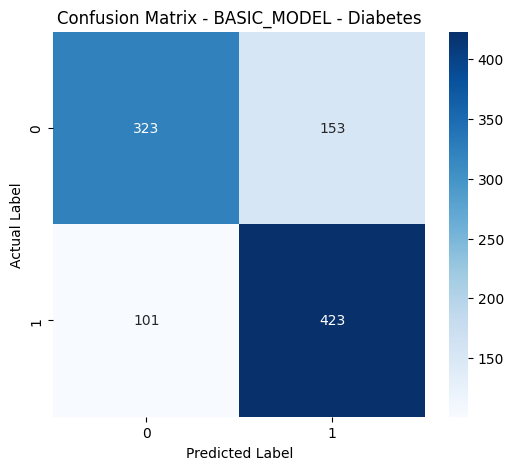

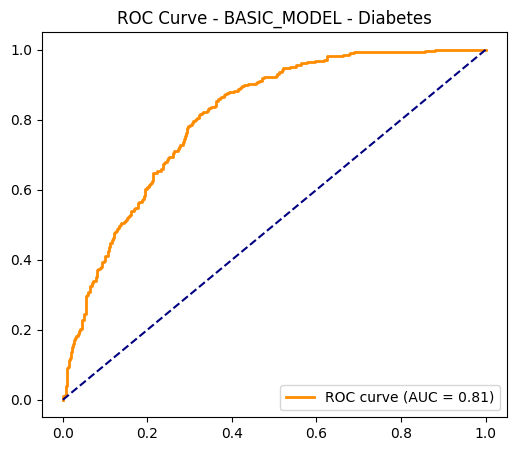


############################################################
RUNNING EXPERIMENT: MODERATE_MODEL
############################################################

LOADING DATA FOR: MODERATE_MODEL...

[MODERATE_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4560

[MODERATE_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.5053

>>> Evaluation for MODERATE_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       453
           1       0.68      0.68      0.68       279

    accuracy                           0.76       732
   macro avg       0.74      0.74      0.74       732
weighted avg       0.76      0.76      0.76       732



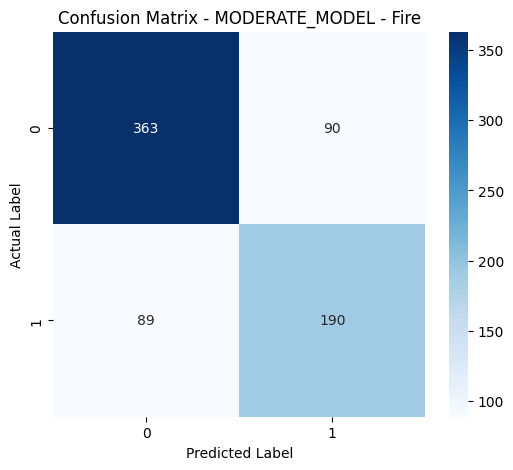

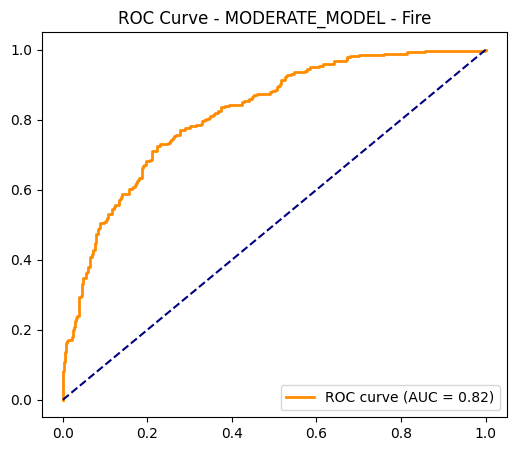


>>> Evaluation for MODERATE_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       476
           1       0.74      0.73      0.73       524

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.73      0.72      0.73      1000



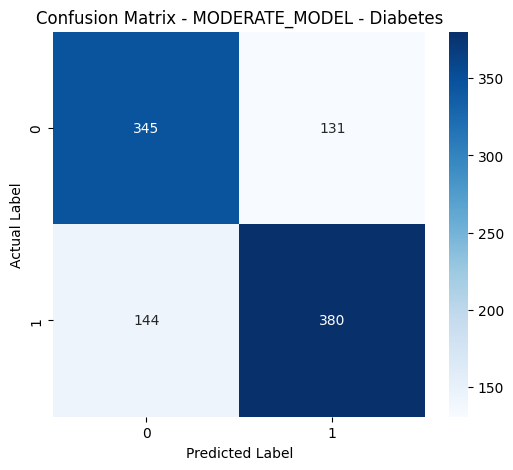

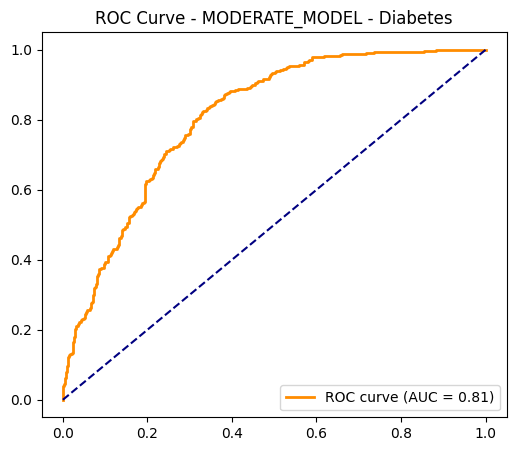


############################################################
RUNNING EXPERIMENT: AGGRESSIVE_MODEL
############################################################

LOADING DATA FOR: AGGRESSIVE_MODEL...

[AGGRESSIVE_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4652

[AGGRESSIVE_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.4967

>>> Evaluation for AGGRESSIVE_MODEL - Fire <<<
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       453
           1       0.70      0.66      0.68       279

    accuracy                           0.77       732
   macro avg       0.75      0.75      0.75       732
weighted avg       0.76      0.77      0.76       732



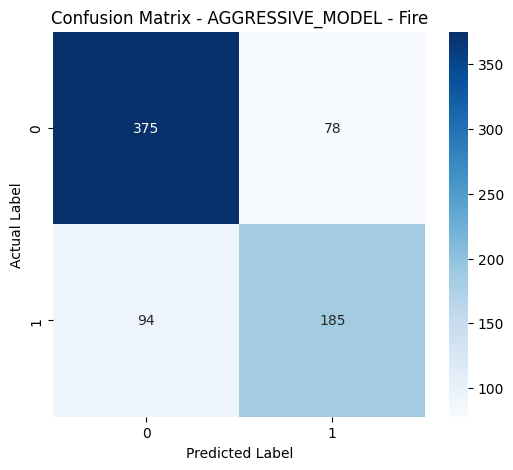

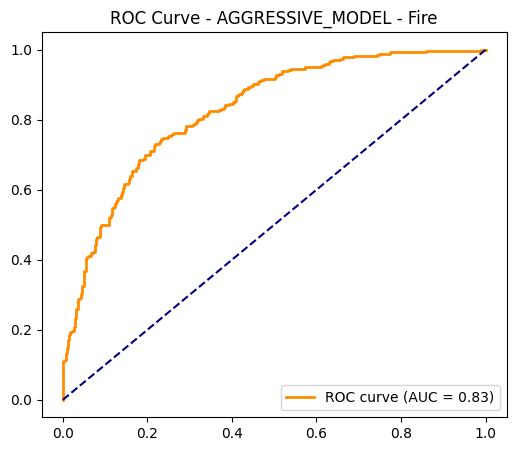


>>> Evaluation for AGGRESSIVE_MODEL - Diabetes <<<
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       476
           1       0.75      0.79      0.77       524

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



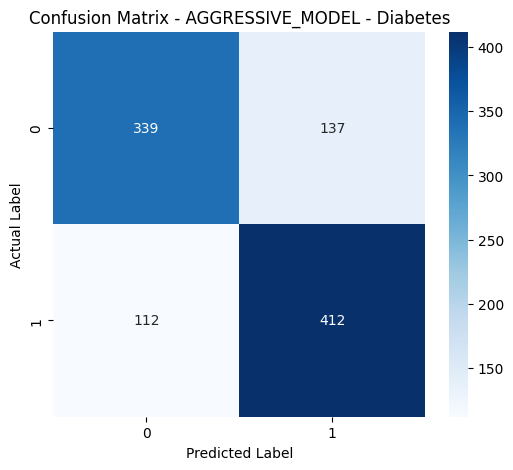

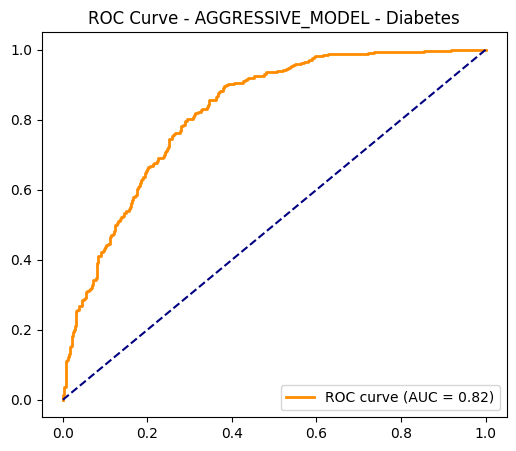

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Model Definition ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.GELU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.GELU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.BatchNorm1d(hidden_size3),
            nn.GELU(),
            nn.Linear(hidden_size3, output_size)
        )

    def forward(self, x):
        return self.network(x)

# --- 2. Utility Classes & Functions ---

class Datasett(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def transform_to_tensors(X_train, X_test, y_train, y_test):
    return (
        torch.tensor(np.array(X_train), dtype=torch.float32),
        torch.tensor(np.array(X_test), dtype=torch.float32),
        torch.tensor(np.array(y_train), dtype=torch.long),
        torch.tensor(np.array(y_test), dtype=torch.long)
    )

#  TRAIN FUNCTION
def train(X_train_full, y_train_full, input_size, epochs, h1, h2, h3, lr, threshold, output_size, patience, delta, weight_decay, batch_size):
    # Ensure inputs are tensors
    if not isinstance(X_train_full, torch.Tensor):
         X_train_full = torch.tensor(X_train_full.values, dtype=torch.float32)
    if not isinstance(y_train_full, torch.Tensor):
         y_train_full = torch.tensor(y_train_full.values, dtype=torch.long)

    # --- CV CONFIGURATION ---
    k_folds = 7
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    best_overall_model = None
    best_overall_loss = float('inf')

    print(f"Starting {k_folds}-Fold Cross-Validation...")

    # --- CROSS-VALIDATION LOOP ---
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_full)):
        # Split data for this specific fold
        X_train_fold = X_train_full[train_idx]
        y_train_fold = y_train_full[train_idx]
        X_val_fold = X_train_full[val_idx]
        y_val_fold = y_train_full[val_idx]

        # Re-initialize a FRESH model for every fold
        model = MLP(input_size, h1, h2, h3, output_size)
        criterion = nn.BCEWithLogitsLoss()

        # Optimizer with Weight Decay (Regularization)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

        early_stopping = EarlyStopping(patience, delta)

        dataset = Datasett(X_train_fold, y_train_fold)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Training Loop for this fold
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y.float())
                loss.backward()
                optimizer.step()

            # Validation step
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_fold)
                val_loss = criterion(val_outputs.squeeze(), y_val_fold.float())

                # Update scheduler
                scheduler.step(val_loss)

                # Check early stopping
                early_stopping(val_loss.item())
                if early_stopping.early_stop:
                    break

        # Get the best loss achieved by THIS fold
        fold_best_loss = early_stopping.best_loss

        #  save best model
        if fold_best_loss < best_overall_loss:
            best_overall_loss = fold_best_loss
            best_overall_model = model

    print(f"   -> Best CV Loss: {best_overall_loss:.4f}")
    return best_overall_model

def plot_roc_curve(y_true, y_probs, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_preds, dataset_name):
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- 3. Pipeline Class ---

class Pipeline:
    def __init__(self, epochs=50, h1=128, h2=64, h3=32, lr=0.001,
                 threshold=0.5, output_size=1, patience=5, delta=0.001,
                 weight_decay=0.0001, batch_size=64):

        self.epochs = epochs
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.lr = lr
        self.threshold = threshold
        self.output_size = output_size
        self.patience = patience
        self.delta = delta
        self.weight_decay = weight_decay
        self.batch_size = batch_size

    def load_and_preprocess_data(self):
        df1 = pd.read_csv('Processed_Fire_Dataset.csv')
        X1 = df1.drop('FIRE_START_DAY', axis=1)
        y1 = df1['FIRE_START_DAY']

        df2 = pd.read_csv('Processed_Diabetes_dataset.csv')
        X2 = df2.drop('Diabetes_binary', axis=1)
        y2 = df2['Diabetes_binary']
        return X1, y1, X2, y2

    def run(self, config_name):
        print(f"\nLOADING DATA FOR: {config_name}...")
        X1, y1, X2, y2 = self.load_and_preprocess_data()

        X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

        scaler1 = StandardScaler()
        X1_train_scaled = scaler1.fit_transform(X1_train)
        X1_test_scaled = scaler1.transform(X1_test)

        scaler2 = StandardScaler()
        X2_train_scaled = scaler2.fit_transform(X2_train)
        X2_test_scaled = scaler2.transform(X2_test)

        self.X1_train, self.X1_test, self.y1_train, self.y1_test = transform_to_tensors(
            X1_train_scaled, X1_test_scaled, y1_train, y1_test
        )
        self.X2_train, self.X2_test, self.y2_train, self.y2_test = transform_to_tensors(
            X2_train_scaled, X2_test_scaled, y2_train, y2_test
        )

        print(f"\n[{config_name}] Training Model 1 (Fire Dataset)")
        input_size1 = self.X1_train.shape[1]
        self.model1 = train(self.X1_train, self.y1_train, input_size1, self.epochs,
                            self.h1, self.h2, self.h3, self.lr, self.threshold,
                            self.output_size, self.patience, self.delta,
                            self.weight_decay, self.batch_size)

        print(f"\n[{config_name}] Training Model 2 (Diabetes Dataset)")
        input_size2 = self.X2_train.shape[1]
        self.model2 = train(self.X2_train, self.y2_train, input_size2, self.epochs,
                            self.h1, self.h2, self.h3, self.lr, self.threshold,
                            self.output_size, self.patience, self.delta,
                            self.weight_decay, self.batch_size)

        self.evaluate(self.model1, self.X1_test, self.y1_test, f"{config_name} - Fire")
        self.evaluate(self.model2, self.X2_test, self.y2_test, f"{config_name} - Diabetes")

    def evaluate(self, model, X_test, y_test, dataset_name):
        model.eval()
        with torch.no_grad():
            logits = model(X_test)
            probs = torch.sigmoid(logits.squeeze())
            preds = (probs > self.threshold).long()

        print(f"\n>>> Evaluation for {dataset_name} <<<")
        print(classification_report(y_test, preds))
        # Uncomment to see plots for every single model (can be spammy)
        plot_confusion_matrix(y_test, preds, dataset_name)
        plot_roc_curve(y_test, probs, dataset_name)


# --- 4. EXECUTION BLOCK ---
if __name__ == "__main__":

    # Define the 3 Configurations
    experiments = [
        {
            "name": "BASIC_MODEL",
            "h1": 64, "h2": 32, "h3": 16,
            "lr": 0.001,
            "weight_decay": 0.0,    # No regularization
            "patience": 5,
            "batch_size": 32,
            "epochs": 50
        },
        {
            "name": "MODERATE_MODEL",
            "h1": 128, "h2": 64, "h3": 32,
            "lr": 0.001,
            "weight_decay": 0.0001, # Standard regularization
            "patience": 8,
            "batch_size": 64,
            "epochs": 75
        },
        {
            "name": "AGGRESSIVE_MODEL",
            "h1": 256, "h2": 128, "h3": 64,
            "lr": 0.01,             # High learning rate
            "weight_decay": 0.001,  # High regularization to combat overfitting
            "patience": 15,         # Wait longer for convergence
            "batch_size": 128,
            "epochs": 150
        }
    ]

    # Loop through experiments
    for exp in experiments:
        print(f"\n{'#'*60}")
        print(f"RUNNING EXPERIMENT: {exp['name']}")
        print(f"{'#'*60}")

        pipeline = Pipeline(
            epochs=exp['epochs'],
            h1=exp['h1'], h2=exp['h2'], h3=exp['h3'],
            lr=exp['lr'],
            weight_decay=exp['weight_decay'],
            patience=exp['patience'],
            batch_size=exp['batch_size']
        )

        pipeline.run(exp['name'])

#Experiment 5:Recall-Optimized


############################################################
RUNNING EXPERIMENT: RECALL_OPTIMIZED_MODEL
############################################################

LOADING DATA FOR: RECALL_OPTIMIZED_MODEL...

[RECALL_OPTIMIZED_MODEL] Training Model 1 (Fire Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.5555

[RECALL_OPTIMIZED_MODEL] Training Model 2 (Diabetes Dataset)
Starting 7-Fold Cross-Validation...
   -> Best CV Loss: 0.5060

>>> Evaluation for RECALL_OPTIMIZED_MODEL - Fire (Threshold: 0.3) <<<
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       453
           1       0.54      0.92      0.68       279

    accuracy                           0.67       732
   macro avg       0.72      0.71      0.66       732
weighted avg       0.77      0.67      0.66       732



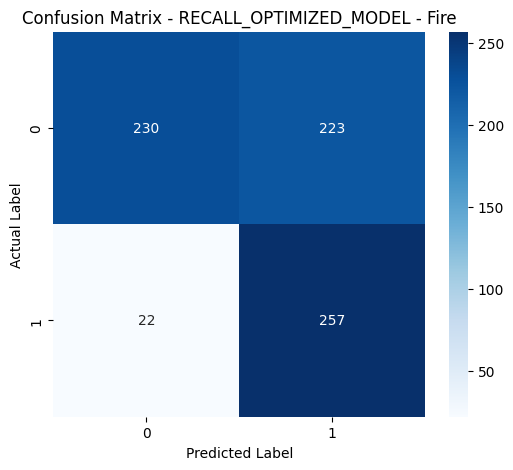

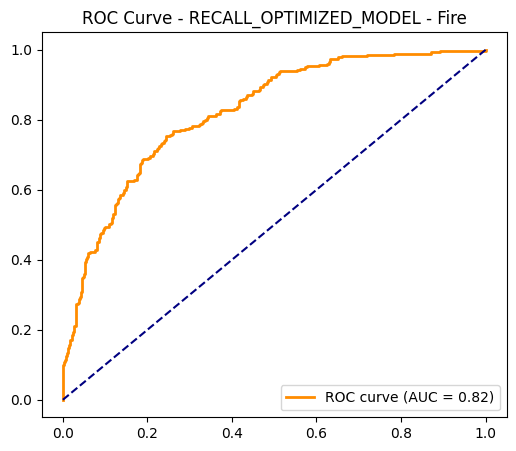


>>> Evaluation for RECALL_OPTIMIZED_MODEL - Diabetes (Threshold: 0.3) <<<
              precision    recall  f1-score   support

           0       0.90      0.47      0.62       476
           1       0.66      0.95      0.78       524

    accuracy                           0.72      1000
   macro avg       0.78      0.71      0.70      1000
weighted avg       0.78      0.72      0.70      1000



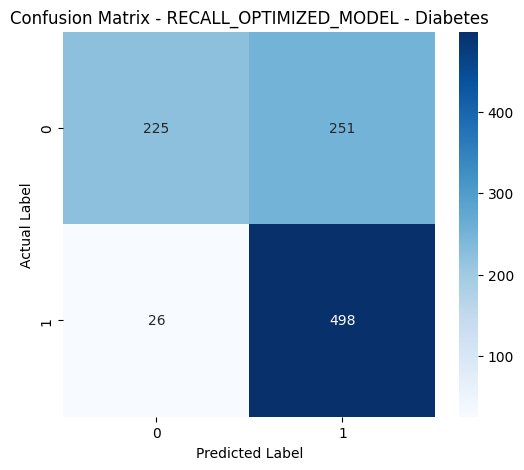

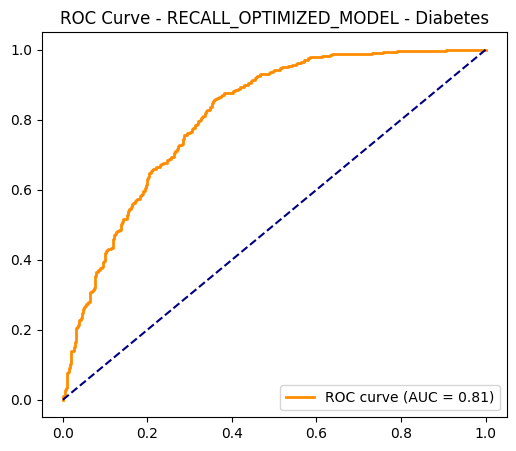

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Model Definition  ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.BatchNorm1d(hidden_size1),
            nn.GELU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.GELU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.BatchNorm1d(hidden_size3),
            nn.GELU(),
            nn.Linear(hidden_size3, output_size)
        )

    def forward(self, x):
        return self.network(x)

# --- 2. Utility Classes & Functions ---

class Datasett(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def transform_to_tensors(X_train, X_test, y_train, y_test):
    return (
        torch.tensor(np.array(X_train), dtype=torch.float32),
        torch.tensor(np.array(X_test), dtype=torch.float32),
        torch.tensor(np.array(y_train), dtype=torch.long),
        torch.tensor(np.array(y_test), dtype=torch.long)
    )

def train(X_train_full, y_train_full, input_size, epochs, h1, h2, h3, lr, threshold, output_size, patience, delta, weight_decay, batch_size):
    if not isinstance(X_train_full, torch.Tensor):
         X_train_full = torch.tensor(X_train_full.values, dtype=torch.float32)
    if not isinstance(y_train_full, torch.Tensor):
         y_train_full = torch.tensor(y_train_full.values, dtype=torch.long)

    k_folds = 7
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    best_overall_model = None
    best_overall_loss = float('inf')

    print(f"Starting {k_folds}-Fold Cross-Validation...")

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_full)):
        X_train_fold = X_train_full[train_idx]
        y_train_fold = y_train_full[train_idx]
        X_val_fold = X_train_full[val_idx]
        y_val_fold = y_train_full[val_idx]

        # --- RECALL OPTIMIZATION: Calculate Class Weights ---
        # Count positive and negative samples in this fold
        num_neg = (y_train_fold == 0).sum().item()
        num_pos = (y_train_fold == 1).sum().item()

        # Calculate weight: Scale up the positive class importance
        # If dataset is 90% neg and 10% pos, weight will be ~9.0
        pos_weight_value = num_neg / (num_pos + 1e-5)
        pos_weight = torch.tensor([pos_weight_value])

        # Re-initialize model
        model = MLP(input_size, h1, h2, h3, output_size)

        # Use Weighted Loss to force model to focus on minority class
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
        early_stopping = EarlyStopping(patience, delta)

        dataset = Datasett(X_train_fold, y_train_fold)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y.float())
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_fold)
                val_loss = criterion(val_outputs.squeeze(), y_val_fold.float())
                scheduler.step(val_loss)
                early_stopping(val_loss.item())
                if early_stopping.early_stop:
                    break

        fold_best_loss = early_stopping.best_loss

        if fold_best_loss < best_overall_loss:
            best_overall_loss = fold_best_loss
            best_overall_model = model

    print(f"   -> Best CV Loss: {best_overall_loss:.4f}")
    return best_overall_model

def plot_roc_curve(y_true, y_probs, dataset_name):
    if isinstance(y_true, torch.Tensor): y_true = y_true.cpu().numpy()
    if isinstance(y_probs, torch.Tensor): y_probs = y_probs.cpu().numpy()

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_preds, dataset_name):
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# --- 3. Pipeline Class ---

class Pipeline:
    def __init__(self, epochs=50, h1=128, h2=64, h3=32, lr=0.001,
                 threshold=0.3, output_size=1, patience=5, delta=0.001,  # Note: Threshold changed to 0.3
                 weight_decay=0.0001, batch_size=64):

        self.epochs = epochs
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.lr = lr
        self.threshold = threshold
        self.output_size = output_size
        self.patience = patience
        self.delta = delta
        self.weight_decay = weight_decay
        self.batch_size = batch_size

    def load_and_preprocess_data(self):
        df1 = pd.read_csv('Processed_Fire_Dataset.csv')
        X1 = df1.drop('FIRE_START_DAY', axis=1)
        y1 = df1['FIRE_START_DAY']

        df2 = pd.read_csv('Processed_Diabetes_dataset.csv')
        X2 = df2.drop('Diabetes_binary', axis=1)
        y2 = df2['Diabetes_binary']
        return X1, y1, X2, y2

    def run(self, config_name):
        print(f"\nLOADING DATA FOR: {config_name}...")
        X1, y1, X2, y2 = self.load_and_preprocess_data()

        X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

        scaler1 = StandardScaler()
        X1_train_scaled = scaler1.fit_transform(X1_train)
        X1_test_scaled = scaler1.transform(X1_test)

        scaler2 = StandardScaler()
        X2_train_scaled = scaler2.fit_transform(X2_train)
        X2_test_scaled = scaler2.transform(X2_test)

        self.X1_train, self.X1_test, self.y1_train, self.y1_test = transform_to_tensors(
            X1_train_scaled, X1_test_scaled, y1_train, y1_test
        )
        self.X2_train, self.X2_test, self.y2_train, self.y2_test = transform_to_tensors(
            X2_train_scaled, X2_test_scaled, y2_train, y2_test
        )

        print(f"\n[{config_name}] Training Model 1 (Fire Dataset)")
        input_size1 = self.X1_train.shape[1]
        self.model1 = train(self.X1_train, self.y1_train, input_size1, self.epochs,
                            self.h1, self.h2, self.h3, self.lr, self.threshold,
                            self.output_size, self.patience, self.delta,
                            self.weight_decay, self.batch_size)

        print(f"\n[{config_name}] Training Model 2 (Diabetes Dataset)")
        input_size2 = self.X2_train.shape[1]
        self.model2 = train(self.X2_train, self.y2_train, input_size2, self.epochs,
                            self.h1, self.h2, self.h3, self.lr, self.threshold,
                            self.output_size, self.patience, self.delta,
                            self.weight_decay, self.batch_size)

        self.evaluate(self.model1, self.X1_test, self.y1_test, f"{config_name} - Fire")
        self.evaluate(self.model2, self.X2_test, self.y2_test, f"{config_name} - Diabetes")

    def evaluate(self, model, X_test, y_test, dataset_name):
        model.eval()
        with torch.no_grad():
            logits = model(X_test)
            probs = torch.sigmoid(logits.squeeze())
            # Use the custom threshold (0.3) for evaluation
            preds = (probs > self.threshold).long()

        print(f"\n>>> Evaluation for {dataset_name} (Threshold: {self.threshold}) <<<")
        print(classification_report(y_test, preds))

        # Uncomment to see plots
        plot_confusion_matrix(y_test, preds, dataset_name)
        plot_roc_curve(y_test, probs, dataset_name)


# --- 4. EXECUTION BLOCK ---
if __name__ == "__main__":

    # We will run the "BASIC" model structure because it proved best for Recall previously.


    experiments = [
        {
            "name": "RECALL_OPTIMIZED_MODEL",
            "h1": 64, "h2": 32, "h3": 16, # Basic size was best for generalization
            "lr": 0.001,
            "weight_decay": 0.0001,
            "patience": 8,
            "batch_size": 32,
            "epochs": 60
        }
    ]

    for exp in experiments:
        print(f"\n{'#'*60}")
        print(f"RUNNING EXPERIMENT: {exp['name']}")
        print(f"{'#'*60}")

        pipeline = Pipeline(
            epochs=exp['epochs'],
            h1=exp['h1'], h2=exp['h2'], h3=exp['h3'],
            lr=exp['lr'],
            threshold=0.3, # <--- Lower threshold explicitly requests higher Recall
            weight_decay=exp['weight_decay'],
            patience=exp['patience'],
            batch_size=exp['batch_size']
        )

        pipeline.run(exp['name'])